In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
%matplotlib inline

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [9]:
# import all elections for Tübingen from 2002 to 2017

elections_2002_Tübingen_df = pd.read_csv('Bundestagswahlen_Wahlbezirke_clean/Tübingen_2002.csv')
elections_2005_Tübingen_df = pd.read_csv('Bundestagswahlen_Wahlbezirke_clean/Tübingen_2005.csv')
elections_2009_Tübingen_df = pd.read_csv('Bundestagswahlen_Wahlbezirke_clean/Tübingen_2009.csv')
elections_2013_Tübingen_df = pd.read_csv('Bundestagswahlen_Wahlbezirke_clean/Tübingen_2013.csv')
elections_2017_Tübingen_df = pd.read_csv('Bundestagswahlen_Wahlbezirke_clean/Tübingen_2017.csv')

years = [2002, 2005, 2009, 2013, 2017]

In [4]:
# check out all districts

elections_2017_Tübingen_df['Wahlbezirk']

0                    011-01 Marktplatz
1          011-02 Innenstadt Nord-West
2                       011-03 Haagtor
3           011-04 Innenstadt Nord-Ost
4                     011-05 Neckartor
5                      012-01 Föhrberg
6                   012-02 Universität
7                 012-03 Schnarrenberg
8                    012-04 Viehweidle
9               012-05 Frischlinstraße
10                   013-01 Wanne-West
11                      013-02 Horemer
12                    013-03 Wanne-Süd
13                    013-04 Wanne-Ost
14                   014-02 Schönblick
15                  014-03 Winkelwiese
16       014-04 Waldhäuser-Ost I (ost)
17     014-05 Waldhäuser-Ost II (west)
18     014-06 Waldhäuser-Ost III (süd)
19                    015-01 Österberg
20                 015-02 Gartenstraße
21        016-01 Französisches Viertel
22              017-01 Schellingstraße
23                  017-02 Volksgarten
24                   017-03 Sternplatz
25              017-04 Ma

In [5]:
elections_2017_Tübingen_df[elections_2017_Tübingen_df['Wahlbezirk'] == '011-01 Marktplatz']

,Unnamed: 0,Wahlbezirk,Gültig,CDU/CSU,SPD,FDP,GRÜNE,DIE LINKE,AfD,PIRATEN,DIE PARTEI,OTHER
0,85751,011-01 Marktplatz,508,67,94,40,148,119,10,1,14,15


In [6]:
elections_2017_Tübingen_df[elections_2017_Tübingen_df['Wahlbezirk'] == '016-01 Französisches Viertel']

,Unnamed: 0,Wahlbezirk,Gültig,CDU/CSU,SPD,FDP,GRÜNE,DIE LINKE,AfD,PIRATEN,DIE PARTEI,OTHER
21,85772,016-01 Französisches Viertel,708,60,83,46,262,198,25,2,9,23


In [8]:
elections_2017_Tübingen_df[elections_2017_Tübingen_df['Wahlbezirk'] == '013-03 Wanne-Süd']

,Unnamed: 0,Wahlbezirk,Gültig,CDU/CSU,SPD,FDP,GRÜNE,DIE LINKE,AfD,PIRATEN,DIE PARTEI,OTHER
12,85763,013-03 Wanne-Süd,558,162,97,90,125,40,31,2,3,8


In [24]:
# drop column "Gebiet"
#small_df = small_df.drop(columns=['Gebiet'])

# apply the Laplace Bridge
def Dirichlet_bridge_mu(alpha):
    alpha = np.array(alpha, dtype='int')
    k = len(alpha)
    C = 1/k * np.sum(np.log(alpha))
    return(np.log(alpha) - C)

def Dirichlet_bridge_Sigma(alpha):
    K = len(alpha)
    Sigma = np.zeros((K, K))
    sum_inv_alphas = np.sum(1/alpha)
    for k in range(K):
        for l in range(K):
            x_ = -1/K * (1/alpha[k] + 1/alpha[l] - 1/K*sum_inv_alphas)
            if k == l:
                x_ += 1/alpha[k]
            Sigma[k,l] = x_
            
    return(Sigma)

def Dirichlet_bridge_alpha(mu, Sigma):
    K = len(mu)
    Sigma_diag = np.diag(Sigma)
    sum_m_exp = np.sum(np.exp(-mu))
    return(1/Sigma_diag * (1 - 2/K + np.exp(mu)/K**2 * sum_m_exp))


def softmax_vector(mu):
    mu = np.array(mu)
    return(np.exp(mu)/np.sum(np.exp(mu)))

def softmax_batch(mu_batch):
    mu_batch = np.array(mu_batch)
    return(np.exp(mu_batch)/np.sum(np.exp(mu_batch), 1)[:,np.newaxis])

# Tübingen elections with Dirichlet + GP (3 selected Wahlbezirke)

In [12]:
# Select the 10 Wahlkreise (Ger + 9 counties) with the 9 parties

cols = ['Wahlbezirk', 'Gültig', 'CDU/CSU', 'SPD', 'FDP', 'GRÜNE',
       'DIE LINKE', 'AfD', 'PIRATEN', 'DIE PARTEI', 'OTHER']

regions = ['011-01 Marktplatz', '013-03 Wanne-Süd', '016-01 Französisches Viertel',
          '011-01', '013-03', '016-01']

parties = ['CDU/CSU', 'SPD', 'FDP', 'GRÜNE', 'DIE LINKE', 'AfD', 'PIRATEN', 'DIE PARTEI', 'OTHER']

n_regions = 3
n_parties = 9

medium_df = pd.DataFrame(columns=cols)
    
dfs = [elections_2002_Tübingen_df, elections_2005_Tübingen_df, elections_2009_Tübingen_df, 
       elections_2013_Tübingen_df, elections_2017_Tübingen_df]
    

for df in dfs:
    df_ = df[cols]
    df_ = df_.loc[df['Wahlbezirk'].isin(regions)]
    medium_df = medium_df.append(df_)


medium_df = medium_df.drop(columns=['Wahlbezirk', 'Gültig'])

assert(len(years) * n_regions == len(medium_df))
    
medium_df

,CDU/CSU,SPD,FDP,GRÜNE,DIE LINKE,AfD,PIRATEN,DIE PARTEI,OTHER
0,92,188,36,209,15,0.0,0.0,0.0,10.0
12,184,159,57,172,11,0.0,0.0,0.0,9.0
22,74,149,34,313,58,0.0,0.0,0.0,12.0
0,114,141,61,214,55,0.0,0.0,0.0,13.0
12,173,161,71,136,12,0.0,0.0,0.0,5.0
22,57,178,42,320,82,0.0,0.0,0.0,10.0
0,62,105,43,228,54,0.0,23.0,0.0,13.0
12,146,146,97,124,20,0.0,12.0,0.0,9.0
22,44,148,57,333,108,0.0,31.0,0.0,13.0
0,94,121,21,151,75,16.0,23.0,0.0,15.0


# Plot Tübingen election results

TODO

# Create the GP + LM

In [15]:
P = np.arange(1,n_parties + 1)
C = np.arange(1,n_regions + 1)

X = np.zeros((len(years)*len(C)*len(P), 3))

print(np.shape(X))
idx = 0
for t in years:
    for c in C:
        for p in P:
            X[idx] = [t, c, p]
            idx += 1
            
print(X[:-10])

(135, 3)
[[2.002e+03 1.000e+00 1.000e+00]
 [2.002e+03 1.000e+00 2.000e+00]
 [2.002e+03 1.000e+00 3.000e+00]
 [2.002e+03 1.000e+00 4.000e+00]
 [2.002e+03 1.000e+00 5.000e+00]
 [2.002e+03 1.000e+00 6.000e+00]
 [2.002e+03 1.000e+00 7.000e+00]
 [2.002e+03 1.000e+00 8.000e+00]
 [2.002e+03 1.000e+00 9.000e+00]
 [2.002e+03 2.000e+00 1.000e+00]
 [2.002e+03 2.000e+00 2.000e+00]
 [2.002e+03 2.000e+00 3.000e+00]
 [2.002e+03 2.000e+00 4.000e+00]
 [2.002e+03 2.000e+00 5.000e+00]
 [2.002e+03 2.000e+00 6.000e+00]
 [2.002e+03 2.000e+00 7.000e+00]
 [2.002e+03 2.000e+00 8.000e+00]
 [2.002e+03 2.000e+00 9.000e+00]
 [2.002e+03 3.000e+00 1.000e+00]
 [2.002e+03 3.000e+00 2.000e+00]
 [2.002e+03 3.000e+00 3.000e+00]
 [2.002e+03 3.000e+00 4.000e+00]
 [2.002e+03 3.000e+00 5.000e+00]
 [2.002e+03 3.000e+00 6.000e+00]
 [2.002e+03 3.000e+00 7.000e+00]
 [2.002e+03 3.000e+00 8.000e+00]
 [2.002e+03 3.000e+00 9.000e+00]
 [2.005e+03 1.000e+00 1.000e+00]
 [2.005e+03 1.000e+00 2.000e+00]
 [2.005e+03 1.000e+00 3.000e+00]
 

(135, 135)


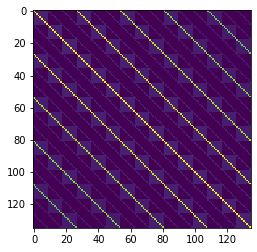

In [22]:
# build the kernel

def k_SEK(x, x_, s=1, l=2):
    return(s*np.exp(-(x-x_)**2 / (2*l**2)))

def k_RQ(x, x_, s=1, l=10, a=0.1):
    return(s**2 * (1 + (x-x_)**2/(2*a*l**2)))**(-a)

def k_dirac_soft(x, x_):
    if x == x_:
        return(1)
    else:
        return(0.1)

n = len(X)
K_XX = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        t_i = X[i,0]
        c_i = X[i,1]
        p_i = X[i,2]
        t_j = X[j,0]
        c_j = X[j,1]
        p_j = X[j,2]
        #K_XX[i, j] = k_SEK(t_i, t_j) * k_dirac_soft(c_i, c_j) * k_dirac_soft(p_i, p_j)
        K_XX[i, j] = k_RQ(t_i, t_j) * k_dirac_soft(c_i, c_j) * k_dirac_soft(p_i, p_j)
        
print(np.shape(K_XX))
K_XX[:10,:10]

plt.imshow(K_XX)
plt.show()

In [25]:
# prep y data

#prior for the dirichlet
alpha_0 = 1

t0 = time.time()
Y_mu = np.array([Dirichlet_bridge_mu(np.array(row[1].values) + alpha_0) for row in medium_df.iterrows()])
t1 = time.time()
print("mu transformation time: ", t1 - t0)
Y_mu = Y_mu.reshape(-1)

#print(Y_mu)

t0 = time.time()
Y_Sigma = [Dirichlet_bridge_Sigma(np.array(row[1].values) + alpha_0) for row in medium_df.iterrows()]
t1 = time.time()
print("Sigma transformation time: ", t1 - t0)

Y_Sigma_block = np.zeros((n,n))
idx = 0
for S in Y_Sigma:
    Y_Sigma_block[idx:idx+n_parties, idx:idx+n_parties] = S
    idx += n_parties

mu transformation time:  0.0022068023681640625
Sigma transformation time:  0.002096891403198242


In [26]:
# compute the equations for the GP

from numpy.random import randn, multivariate_normal
from numpy.linalg import cholesky, solve
from scipy.linalg import cho_solve, cho_factor
import time

G_ = K_XX + Y_Sigma_block
t0 = time.time()
G = cho_factor(G_)
t1 = time.time()
print("time for cho factor: ", t1 - t0)

time for cho factor:  0.004678010940551758


In [66]:
#make predictions for all years in between the elections

T_x = np.arange(2002, 2017+1)
P_x = np.arange(1,n_parties + 1)
C_x = np.arange(1,n_regions + 1)

x = np.zeros((len(T_x)*len(C_x)*len(P_x), 3))
print(np.shape(x))
idx = 0
for t in T_x:
    for c in C_x:
        for p in P_x:
            x[idx] = [t, c, p]
            idx += 1

n_ = len(x)
K_xX = np.zeros((n_, n))
for i in range(n_):
    for j in range(n):
        t_i = x[i,0]
        c_i = x[i,1]
        p_i = x[i,2]
        t_j = X[j,0]
        c_j = X[j,1]
        p_j = X[j,2]
        #K_xX[i, j] = k_SEK(t_i, t_j) * k_dirac_soft(c_i, c_j) * k_dirac_soft(p_i, p_j)
        K_xX[i, j] = k_RQ(t_i, t_j) * k_dirac_soft(c_i, c_j) * k_dirac_soft(p_i, p_j)
        
print(np.shape(K_xX))

K_xx = np.zeros((n_, n_))
for i in range(n_):
    for j in range(n_):
        t_i = x[i,0]
        c_i = x[i,1]
        p_i = x[i,2]
        t_j = x[j,0]
        c_j = x[j,1]
        p_j = x[j,2]
        #K_xx[i, j] = k_SEK(t_i, t_j) * k_dirac_soft(c_i, c_j) * k_dirac_soft(p_i, p_j)
        K_xx[i, j] = k_RQ(t_i, t_j) * k_dirac_soft(c_i, c_j) * k_dirac_soft(p_i, p_j)
        
print(np.shape(K_xx))

(432, 3)
(432, 135)
(432, 432)


In [67]:
# do some inference 
t0 = time.time()
A = cho_solve(G, K_xX.T).T
t1 = time.time()
print("cho solve: ", t1-t0)

out = {}

# # posterior p(f_x|Y) = N(f_x,mpost,vpost)
t0 = time.time()
out["mpost"] = A @ Y_mu #m(x) + A @ (Y - mX)  # mean
t1 = time.time()
print("matrix multiplication with mu: ", t1-t0)
print(np.shape(out['mpost']))

t0 = time.time()
out["vpost"] = K_xx - A @ K_xX.T  # covariance
t1 = time.time()
print("Computing Kernel for prediction: ", t1-t0)
print(np.shape(out['vpost']))

n_GP_samples = 50

#This makes the kernel die because it's too large
out["spost"] = multivariate_normal(
    out["mpost"].flatten(), out["vpost"], size=n_GP_samples
)

cho solve:  0.002697467803955078
matrix multiplication with mu:  0.0023844242095947266
(432,)
Computing Kernel for prediction:  0.0039501190185546875
(432, 432)


In [68]:
Tübingen_pred = out["mpost"]
Tübingen_pred_v = np.diag(out["vpost"])
print(np.shape(Tübingen_pred))
print(np.shape(Tübingen_pred_v))

Tübingen_pred = Tübingen_pred.reshape((-1, n_regions*n_parties))
Tübingen_pred_v = Tübingen_pred_v.reshape((-1, n_regions*n_parties))

Tübingen_pred_Markt = Tübingen_pred[:, :n_parties]
Tübingen_pred_Wanne = Tübingen_pred[:, n_parties:2*n_parties]
Tübingen_pred_Franz = Tübingen_pred[:, 2*n_parties:3*n_parties]

Tübingen_pred_Markt_v = Tübingen_pred_v[:, :n_parties]
Tübingen_pred_Wanne_v = Tübingen_pred_v[:, n_parties:2*n_parties]
Tübingen_pred_Franz_v = Tübingen_pred_v[:, 2*n_parties:3*n_parties]

print(np.shape(Tübingen_pred_Markt))
print(np.shape(Tübingen_pred_Markt_v))

(432,)
(432,)
(16, 9)
(16, 9)


In [69]:
# Bridge back to Dirichlet land via softmax

sm_results_Markt = softmax_batch(Tübingen_pred_Markt)
sm_cumulative_Markt = np.cumsum(sm_results_Markt, 1)

sm_results_Wanne = softmax_batch(Tübingen_pred_Wanne)
sm_cumulative_Wanne = np.cumsum(sm_results_Wanne, 1)

sm_results_Franz = softmax_batch(Tübingen_pred_Franz)
sm_cumulative_Franz = np.cumsum(sm_results_Franz, 1)


In [70]:
#parties = ['CDU/CSU', 'SPD', 'FDP', 'GRÜNE', 'DIE LINKE', 'AfD', 'PIRATEN', 'DIE PARTEI', 'OTHER']

party_colors = {
    'CDU/CSU':'black',
    'SPD':'red',
    'FDP':'yellow',
    'GRÜNE':'green',
    'DIE LINKE':'magenta',
    'AfD':'deepskyblue',
    'PIRATEN':'purple',
    'DIE PARTEI':'firebrick',
    'OTHER':'grey'
}

In [71]:
def plot_results(sm_result, results_v, filename,  save=False, x=T_x, legend=True):
    
    plt.rcParams["font.weight"] = "normal"
    plt.rcParams["axes.labelweight"] = "normal"
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.labelsize'] = 20
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = "Times New Roman"
    legend_size=25
    #xlabel_size=25
    #ylabel_size=25
    #title_size=25
    lw_size=3

    plt.figure(figsize=(15, 7))
    plt.xlim((np.min(T_x), np.max(T_x)))
    for i in range(n_parties):
        plt.plot(x, sm_result[:, i], label=parties[i], color=party_colors[parties[i]], lw=3)
        plt.plot(x, sm_result[:, i] + results_v[:, i], color=party_colors[parties[i]], lw=1)
        plt.plot(x, sm_result[:, i] - results_v[:, i], color=party_colors[parties[i]], lw=1)

    if legend:
        plt.legend(prop={'size': legend_size})    
    plt.tight_layout()
    if save:
        plt.savefig(filename)
    plt.show();

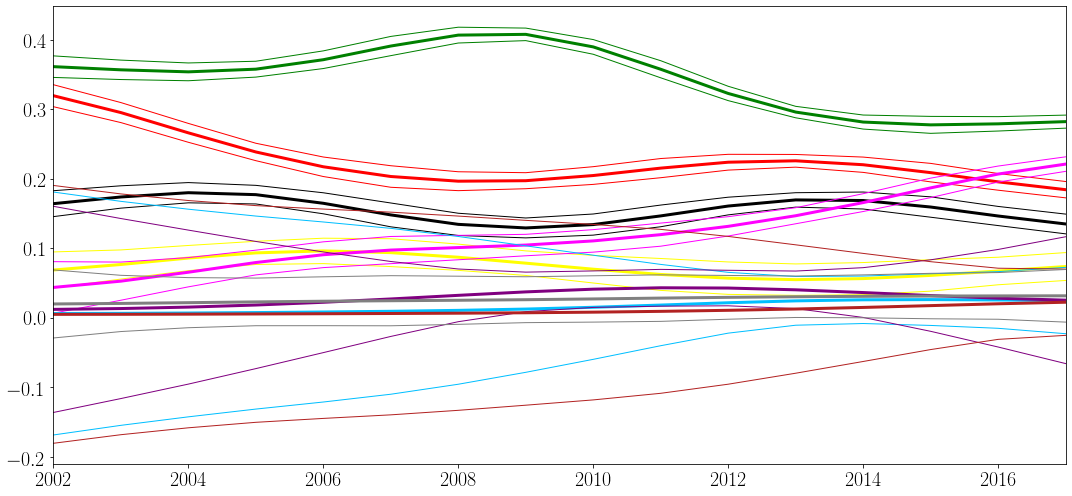

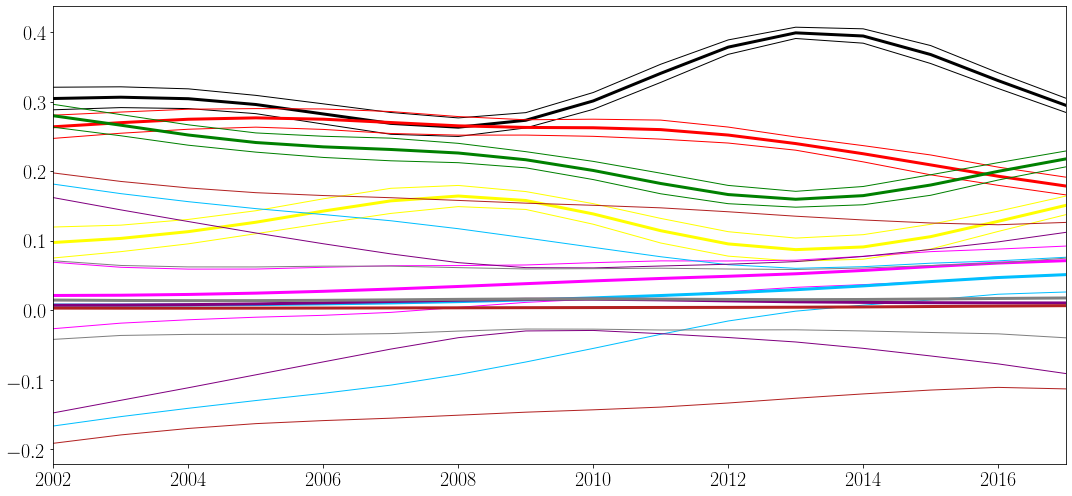

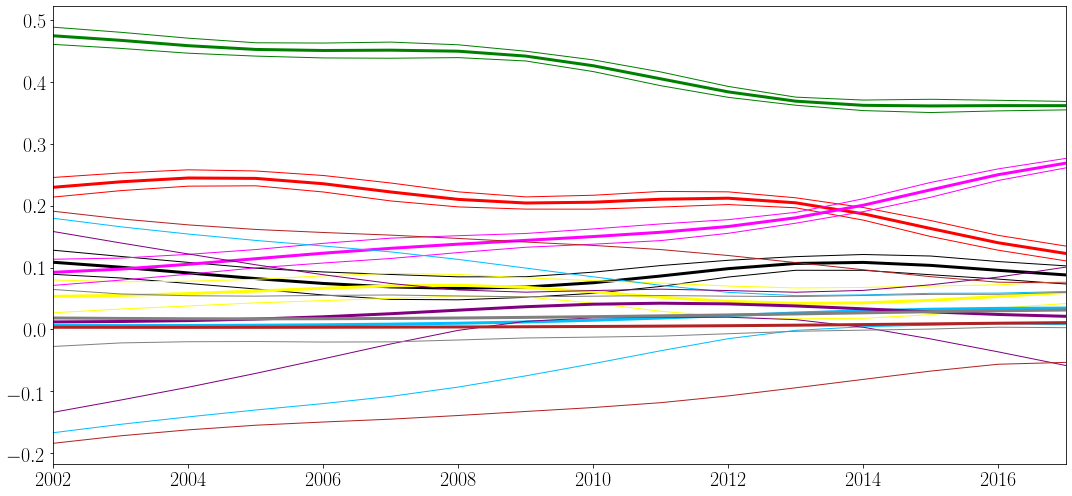

In [72]:
sm_results = [sm_results_Markt, sm_results_Wanne, sm_results_Franz]

results_v = [Tübingen_pred_Markt_v, Tübingen_pred_Wanne_v, Tübingen_pred_Franz_v]

filenames = ['sm_Markt.pdf', 'sm_Wanne.pdf', 'sm_Franz.pdf']

for j in range(len(sm_results)):
    
    r = sm_results[j]
    v = results_v[j]
    plot_results(r, v, filename=filenames[j], save=False, legend=False)

In [73]:

def plot_cum_results(sm_results_cum, results_v, x=T_x, save=False, filename='test.pdf', legend=False):

    plt.rc('text', usetex=True)
    plt.rc('xtick', labelsize=32)
    plt.rc('ytick', labelsize=35)
    plt.rc('axes', labelsize=35)
    legend_size=28
    #xlabel_size=25
    #ylabel_size=25
    #title_size=25
    lw_size=3
    
    fig = plt.figure(figsize=(15, 7))
    plt.ylim((0.0, 1.00))
    plt.xlim((np.min(T_x), np.max(T_x)))
    for i in range(n_parties):
        c = party_colors[parties[i]]
        
        plt.plot(x, sm_results_cum[:, i], label=parties[i], color=c)
        y2 = sm_results_cum[:, i].astype('float')
        if i == 0:
            plt.fill_between(x, y1=np.zeros(len(sm_results_cum)), y2=y2, color=c)
        else:
            y1 = sm_results_cum[:, i-1].astype('float')
            plt.fill_between(x, y1=y1, y2=y2, color=party_colors[parties[i]])
    
    if legend:
        leg = plt.legend(prop={'size': legend_size}) 
        # set the linewidth of each legend object
        for legobj in leg.legendHandles:
            legobj.set_linewidth(15.0)
        
    fig.tight_layout()
    if save:
        plt.savefig(filename)
        plt.show();

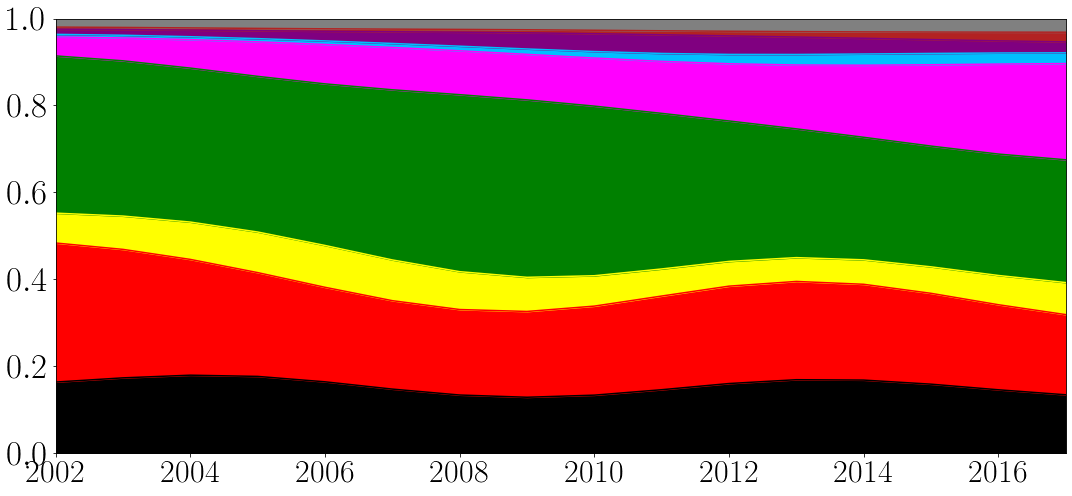

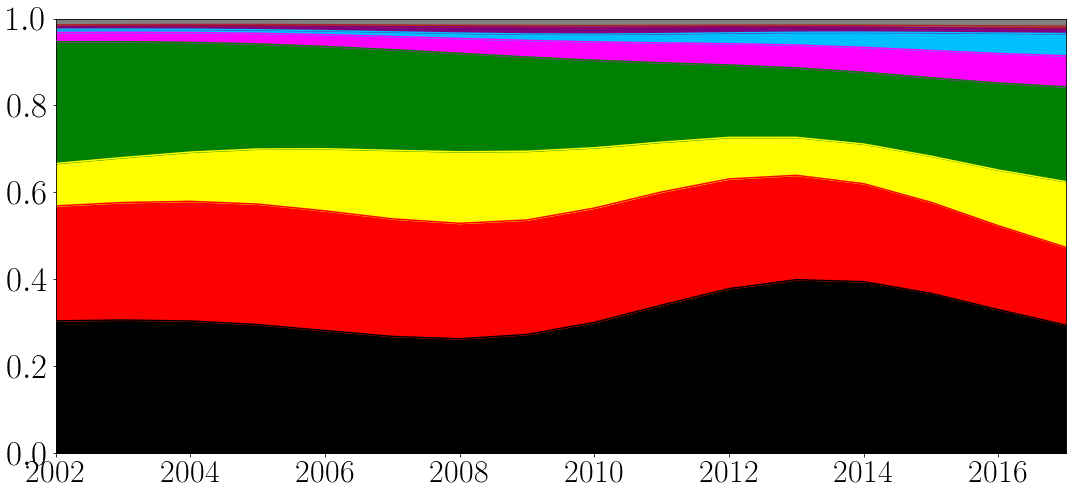

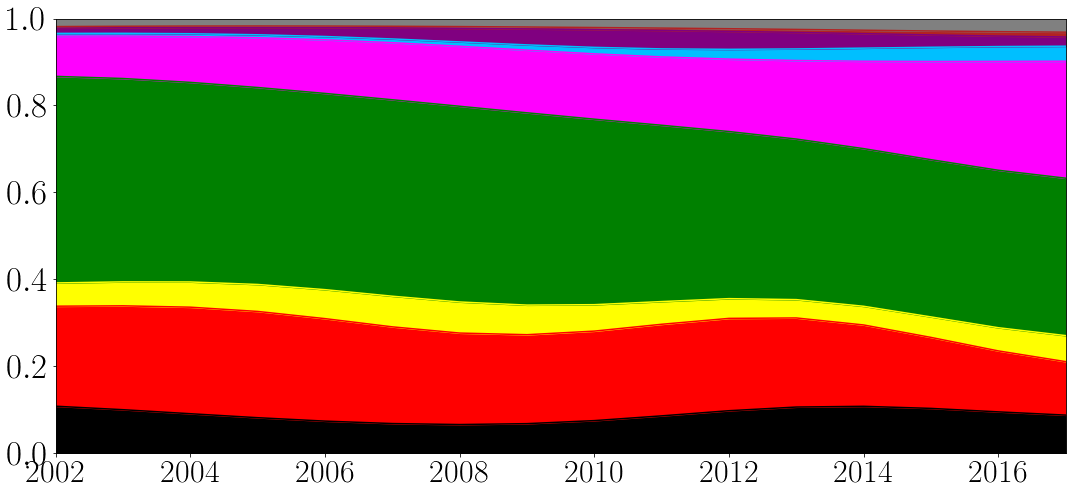

In [74]:
sm_cum_results = [sm_cumulative_Markt, sm_cumulative_Wanne, sm_cumulative_Franz]

filenames = ['sm_Markt_cum.pdf', 'sm_Wanne_cum.pdf', 'sm_Franz_cum.pdf']

for i in range(len(sm_cum_results)):
    
    r = sm_cum_results[i]
    v = results_v[i]
    plot_cum_results(r, v, save=False, filename=filenames[i], legend=False)

In [75]:
# data prep for the GP+LM samples

election_GP_samples = out["spost"]
print(election_GP_samples.shape)

election_GP_samples = election_GP_samples.reshape((n_GP_samples,-1, n_regions*n_parties))
print(election_GP_samples.shape)

Tübingen_pred_Markt_GP_s = election_GP_samples[:, :, :n_parties]
Tübingen_pred_Wanne_GP_s = election_GP_samples[:, :, n_parties:2*n_parties]
Tübingen_pred_Franz_GP_s = election_GP_samples[:, :, 2*n_parties:3*n_parties]

sm_results_Markt_GP_s = np.array([softmax_batch(s_i) for s_i in Tübingen_pred_Markt_GP_s]) 
sm_cumulative_Markt_GP_s = np.cumsum(sm_results_Markt_GP_s, 2)

sm_results_Wanne_GP_s = np.array([softmax_batch(s_i) for s_i in Tübingen_pred_Wanne_GP_s]) 
sm_cumulative_Wanne_GP_s = np.cumsum(sm_results_Wanne_GP_s, 2)

sm_results_Franz_GP_s = np.array([softmax_batch(s_i) for s_i in Tübingen_pred_Franz_GP_s]) 
sm_cumulative_Franz_GP_s = np.cumsum(sm_results_Franz_GP_s, 2)

print(np.shape(sm_results_Markt_GP_s))
print(np.shape(sm_cumulative_Markt_GP_s))

(50, 432)
(50, 16, 27)
(50, 16, 9)
(50, 16, 9)


In [76]:
# create plot for samples instead of color strengths


def plot_samples_cum(samples_cum, sm_results_cum, save=False, filename='test.pdf', x=T_x, legend=False):
    
    plt.rc('text', usetex=True)
    plt.rc('xtick', labelsize=32)
    plt.rc('ytick', labelsize=35)
    plt.rc('axes', labelsize=35)
    legend_size=28
    #xlabel_size=25
    #ylabel_size=25
    #title_size=25
    lw_size=3
    
    fig = plt.figure(figsize=(15, 7))
    plt.ylim((0.0, 1.00))
    plt.xlim((np.min(T_x), np.max(T_x)))
    
    #plot the means and fill between
    alpha_fill = 0.4
    alpha_samples = 0.6
    
    #"""
    for i in range(n_parties):
        c = party_colors[parties[i]]
        
        plt.plot(x, sm_results_cum[:, i], label=parties[i], color=c)
        y2 = sm_results_cum[:, i].astype('float')
        if i == 0:
            plt.fill_between(x, y1=np.zeros(len(sm_results_cum)), y2=y2, color=c, alpha=alpha_fill)
        else:
            y1 = sm_results_cum[:, i-1].astype('float')
            plt.fill_between(x, y1=y1, y2=y2, color=c, alpha=alpha_fill)
    #"""
    
    #plot all samples
    for s in samples_cum:
        
        for i in range(n_parties):
            c = party_colors[parties[i]]
            
            plt.plot(x, s[:, i], label=parties[i], color=c, alpha=alpha_samples)
            
            """
            y2 = s[:, i].astype('float')
            if i == 0:
                plt.fill_between(x, y1=np.zeros(len(s)), y2=y2, color=c, alpha=alpha_fill)
            else:
                y1 = s[:, i-1].astype('float')
                plt.fill_between(x, y1=y1, y2=y2, color=c, alpha=alpha_fill)
            """    
    
    
    if legend:
        leg = plt.legend(prop={'size': legend_size}) 
        # set the linewidth of each legend object
        for legobj in leg.legendHandles:
            legobj.set_linewidth(15.0)
        
    fig.tight_layout()
    if save:
        plt.savefig(filename)
        plt.show();
        

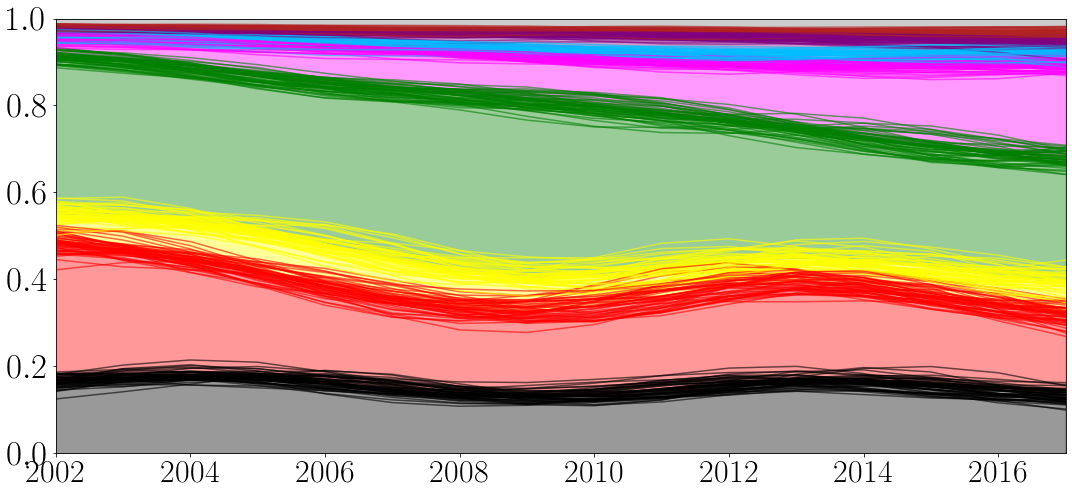

In [77]:
# plot it

plot_samples_cum(sm_cumulative_Markt_GP_s, sm_cumulative_Markt, save=False, filename='elections_GP_samples.pdf', legend=False)

In [78]:
import matplotlib.colors as mcolors
from matplotlib.patches import Polygon

def plot_cum_results2(sm_results_cum, results_v, x=T_x, save=False, filename='test.pdf', legend=True):

    plt.rc('text', usetex=True)
    plt.rc('xtick', labelsize=32)
    plt.rc('ytick', labelsize=35)
    plt.rc('axes', labelsize=35)
    legend_size=28
    #xlabel_size=25
    #ylabel_size=25
    #title_size=25
    lw_size=3
    
    plt.figure(figsize=(15, 7))
    plt.ylim((0.0, 1.00))
    lb = 0
    r_prev = np.zeros(x.max() - x.min()+1)
    
    v_min, v_max = results_v.min(), results_v.max()
    for i in range(n_parties):
        
        c = party_colors[parties[i]]
        r = sm_results_cum[:,i].astype('float')
        n = len(r)
        v = results_v[:, i].astype('float')
        #v_min, v_max = v.min(), v.max()
        #c = mc.to_rgba_array(c).reshape(-1,4)
        #c_a = np.tile(c,(n,1)).reshape(-1,4)
        #c_a[:, -1] = v
        #c_a = [tuple(x.reshape(-1)) for x in c_a]
        #print(c_a)
        
        #ax = plt.gca()
        y_min, y_max = r.min(), r.max()
        x_min, x_max = x.min(), x.max()
        
        ax = plt.gca()
        line, = ax.plot(x, r, color=c, label = parties[i])
            
        zorder = line.get_zorder()
        
        z = np.empty((x_max - x_min+1, 1, 4), dtype=float)
        c_norm = 1/v * v_min
        rgb = mcolors.colorConverter.to_rgb(c)
        z[:,:,:3] = rgb
        z[:,:,-1] = c_norm.reshape(-1,1)
        z = z.reshape(1, -1, 4)
        
        im = ax.imshow(z, aspect='auto', extent=[x_min, x_max, lb, y_max], origin='lower', zorder=zorder)
        
        xy = np.column_stack([x, r])
        xy_prev = np.column_stack([x, r_prev])[::-1]
        #print(xy_prev)
        xy = np.vstack([[x_min, lb], xy, [x_max, lb], xy_prev])
        #xy = np.vstack([[xmin, ymin], xy, [xmax, ymin] , [xmin, ymin]])
        clip_path = Polygon(xy, facecolor='none', edgecolor='none', closed=True)
        ax.add_patch(clip_path)
        im.set_clip_path(clip_path)
        
        lb = y_min
        r_prev = r
    
    if legend:
        plt.legend(prop={'size': legend_size})        

    plt.tight_layout()
    if save:
        plt.savefig(filename)
        plt.show();

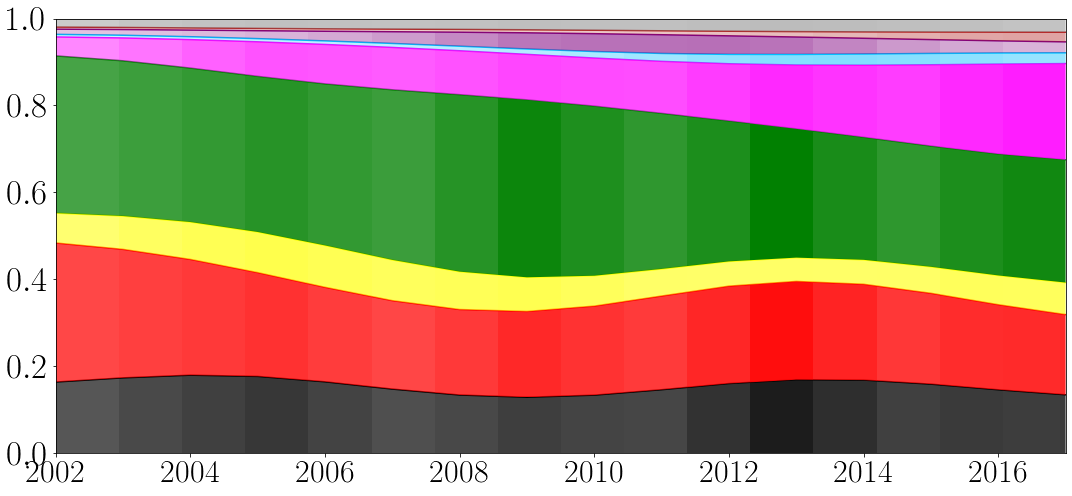

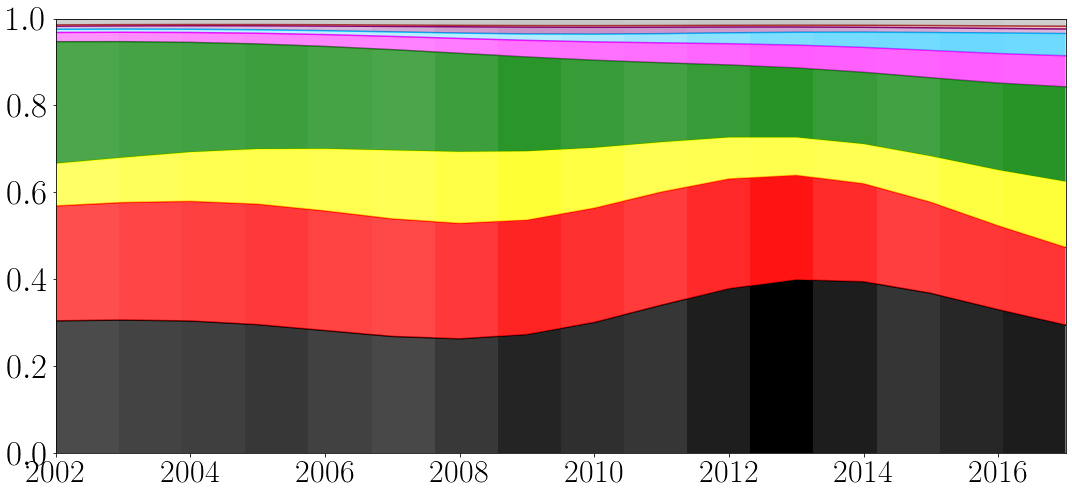

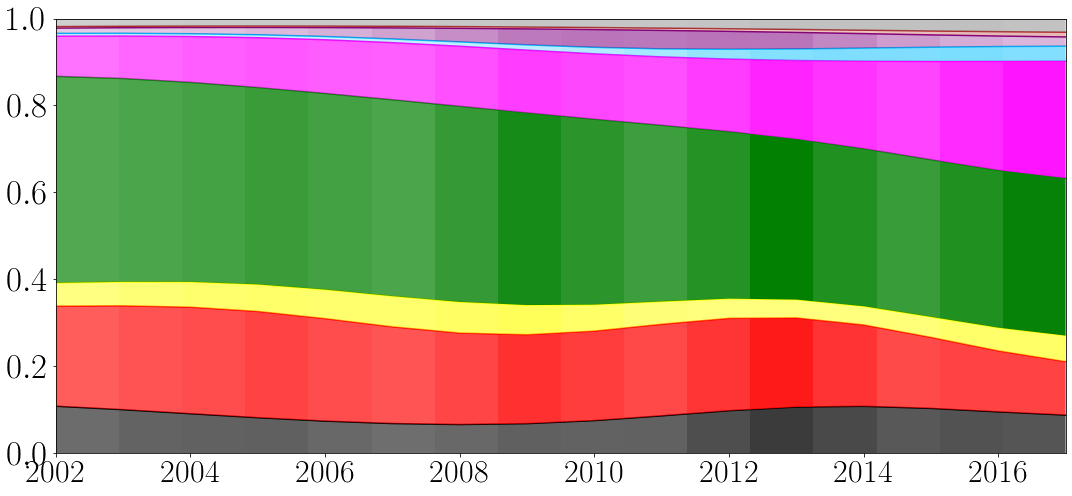

In [79]:
sm_cum_results = [sm_cumulative_Markt, sm_cumulative_Wanne, sm_cumulative_Franz]

filenames2 = ['sm_Markt_cum.pdf', 'sm_Wanne_cum.pdf', 'sm_Franz_cum.pdf']

for i in range(len(sm_cum_results)):
    
    r = sm_cum_results[i]
    v = np.sqrt(results_v[i])
    plot_cum_results2(r, v, save=False, filename=filenames2[i], legend=False)
    

In [80]:
#TODO add other plots

# Compare this to elliptical slice sampling

In [81]:
#
# Elliptical slice sampling
#
import math
def elliptical_slice(initial_theta,prior,lnpdf,pdf_params=(),
                     cur_lnpdf=None,angle_range=None):
    """
    NAME:
       elliptical_slice
    PURPOSE:
       Markov chain update for a distribution with a Gaussian "prior" factored out
    INPUT:
       initial_theta - initial vector
       prior - cholesky decomposition of the covariance matrix 
               (like what numpy.linalg.cholesky returns), 
               or a sample from the prior
       lnpdf - function evaluating the log of the pdf to be sampled
       pdf_params= parameters to pass to the pdf
       cur_lnpdf= value of lnpdf at initial_theta (optional)
       angle_range= Default 0: explore whole ellipse with break point at
                    first rejection. Set in (0,2*pi] to explore a bracket of
                    the specified width centred uniformly at random.
    OUTPUT:
       new_theta, new_lnpdf
    HISTORY:
       Originally written in matlab by Iain Murray (http://homepages.inf.ed.ac.uk/imurray2/pub/10ess/elliptical_slice.m)
       2012-02-24 - Written - Bovy (IAS)
    """
    D= len(initial_theta)
    if cur_lnpdf is None:
        cur_lnpdf= lnpdf(initial_theta,*pdf_params)

    # Set up the ellipse and the slice threshold
    if len(prior.shape) == 1: #prior = prior sample
        nu= prior
        print("first condition is True")
    else: #prior = cholesky decomp
        if not prior.shape[0] == D or not prior.shape[1] == D:
            raise IOError("Prior must be given by a D-element sample or DxD chol(Sigma)")
        nu= np.dot(prior,np.random.normal(size=D))
    hh = math.log(np.random.uniform()) + cur_lnpdf

    # Set up a bracket of angles and pick a first proposal.
    # "phi = (theta'-theta)" is a change in angle.
    if angle_range is None or angle_range == 0.:
        # Bracket whole ellipse with both edges at first proposed point
        phi= np.random.uniform()*2.*math.pi
        phi_min= phi-2.*math.pi
        phi_max= phi
    else:
        # Randomly center bracket on current point
        phi_min= -angle_range*np.random.uniform()
        phi_max= phi_min + angle_range
        phi= np.random.uniform()*(phi_max-phi_min)+phi_min

    #print("nu: ", np.shape(nu))
    #print("nu*math.sin(phi): ", np.shape(nu*math.sin(phi)))
    #print("initial_theta*math.cos(phi): ", np.shape(initial_theta*math.cos(phi)))
        
    # Slice sampling loop
    while True:
        # Compute xx for proposed angle difference and check if it's on the slice
        xx_prop = (initial_theta*math.cos(phi)).reshape(-1) + (nu*math.sin(phi)).reshape(-1)
        #print("xx_prop: ", np.shape(xx_prop))
        cur_lnpdf = lnpdf(xx_prop,*pdf_params)
        if cur_lnpdf > hh:
            # New point is on slice, ** EXIT LOOP **
            break
        # Shrink slice to rejected point
        if phi > 0:
            phi_max = phi
        elif phi < 0:
            phi_min = phi
        else:
            raise RuntimeError('BUG DETECTED: Shrunk to current position and still not acceptable.')
        # Propose new angle difference
        phi = np.random.uniform()*(phi_max - phi_min) + phi_min
    return (xx_prop,cur_lnpdf)

In [82]:
# apply the ESS algorithm to get samples
from scipy.special import logsumexp

y_values = medium_df.reset_index(drop=True).values

# define the log-likelihood as log prod_t prod_c prod_p softmax(f(t,c))[p]^y[t,c,p]
# we can pull the log in to get sums and logsumexps for the softmax

def log_likelihood(x, y=y_values, n_parties=n_parties):
    #TODO: what is x, y, n_parties
    
    #reshape the vector such that we have p columns for the parties and every row is one [t,c]
    x_ = x.reshape(-1, n_parties)
    y_ = y.reshape(-1, n_parties)
    
    #apply the log softmax to all rows in parallel
    x_sm = x_ - logsumexp(x_, axis=1).reshape(-1, 1)
    
    #take all softmax points to the power of the corresponding vote count y
    x_sm_y = x_sm * y_
    
    #return the sum over everything as the log-likelihood
    return(np.sum(x_sm_y))

n_samples = 5000
burn_in = 100#25000 #100000 #after 25000 there are only minor improvements in ll. 

"""
# draw the first f_x from our prior GP with mean 0 and Cov k_XX
f_x = multivariate_normal(
    np.zeros(n), K_XX, size=1
).T
"""

# 'cheat' by choosing the init from the true observed probabilities
y_norm = np.array(y_values/y_values.sum(1).reshape(-1,1), dtype=float) + 10e-8 # <- to prevent the 0s
log_ = np.log(y_norm)
f_x = log_ - log_.sum(1).reshape(-1,1)
f_x = f_x.reshape(-1)

L = np.linalg.cholesky(G_)

post_samples = np.zeros((n_samples, n))

print("L: ", np.shape(L))

t0 = time.time()
# get many samples with ESS
for i in range(-burn_in, n_samples):
    #sample one sample
    f_x, ll = elliptical_slice(initial_theta=f_x, prior=L, lnpdf=log_likelihood) 
    if i % 50 == 0: 
            print("iteration: ", i)
            print("log-likelihood: ", ll)
    if i >= 0:
        post_samples[i] = f_x
        
t1 = time.time()
print("time to take samples: ", t1-t0)



L:  (135, 135)
iteration:  -100
log-likelihood:  -14179.255626939248
iteration:  -50
log-likelihood:  -14188.211207792954
iteration:  0
log-likelihood:  -14188.468644107987
iteration:  50
log-likelihood:  -14192.867143492243
iteration:  100
log-likelihood:  -14193.943349158382
iteration:  150
log-likelihood:  -14194.905058788454
iteration:  200
log-likelihood:  -14206.935780616863
iteration:  250
log-likelihood:  -14212.628378001888
iteration:  300
log-likelihood:  -14208.887652317326
iteration:  350
log-likelihood:  -14207.968097758414
iteration:  400
log-likelihood:  -14208.680632516123
iteration:  450
log-likelihood:  -14213.025509836909
iteration:  500
log-likelihood:  -14211.168420112723
iteration:  550
log-likelihood:  -14212.962891761137
iteration:  600
log-likelihood:  -14210.06778763091
iteration:  650
log-likelihood:  -14213.822737430966
iteration:  700
log-likelihood:  -14208.36163935786
iteration:  750
log-likelihood:  -14203.93792466524
iteration:  800
log-likelihood:  -14

In [83]:
# check out predictions

K = out["vpost"] 

print(np.shape(post_samples))

sample_mean = post_samples.mean(axis=0)
sample_std = post_samples.std(axis=0)

(5000, 135)


In [84]:
sample_pred = [A @ s for s in post_samples]
sample_pred_mean = A @ sample_mean
sample_pred_std = np.std(sample_pred, 0)

print(np.shape(sample_pred_mean))
print(np.shape(sample_pred_std))

(432,)
(432,)


In [85]:
sample_pred_mean = sample_pred_mean.reshape((-1, n_regions*n_parties))
sample_pred_std = sample_pred_std.reshape((-1, n_regions*n_parties))

sample_pred_Markt = sample_pred_mean[:, :n_parties]
sample_pred_Wanne = sample_pred_mean[:, n_parties:2*n_parties]
sample_pred_Franz = sample_pred_mean[:, 2*n_parties:3*n_parties]

sample_pred_Markt_std = sample_pred_std[:, :n_parties]
sample_pred_Wanne_std = sample_pred_std[:, n_parties:2*n_parties]
sample_pred_Franz_std = sample_pred_std[:, 2*n_parties:3*n_parties]

print(np.shape(sample_pred_Markt))
print(np.shape(sample_pred_Markt_std))

(16, 9)
(16, 9)


In [86]:
sm_s_results_Markt = softmax_batch(sample_pred_Markt)
sm_s_cumulative_Markt = np.cumsum(sm_s_results_Markt, 1)

sm_s_results_Wanne = softmax_batch(sample_pred_Wanne)
sm_s_cumulative_Wanne = np.cumsum(sm_s_results_Wanne, 1)

sm_s_results_Franz = softmax_batch(sample_pred_Franz)
sm_s_cumulative_Franz = np.cumsum(sm_s_results_Franz, 1)

print(np.shape(sm_s_results_Markt))
print(np.shape(sm_results_Markt))

(16, 9)
(16, 9)


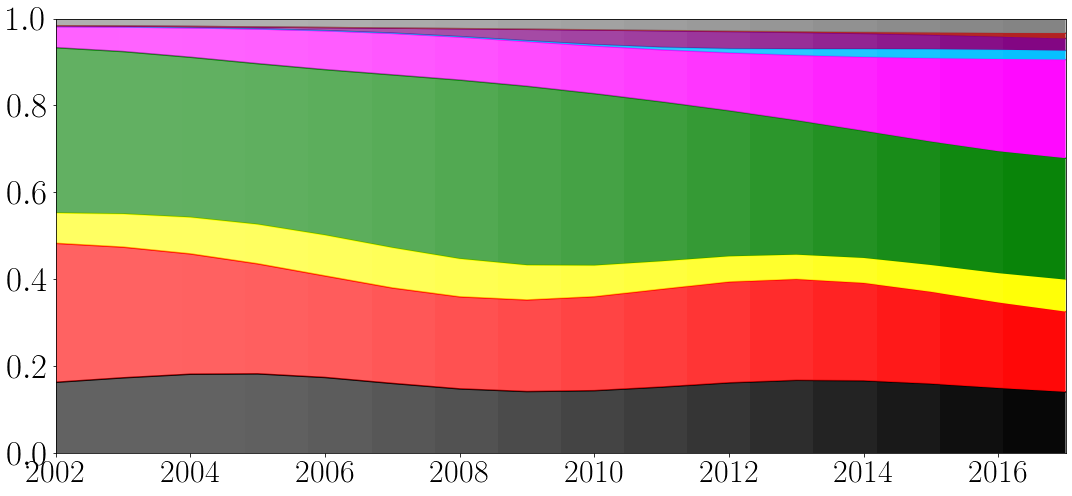

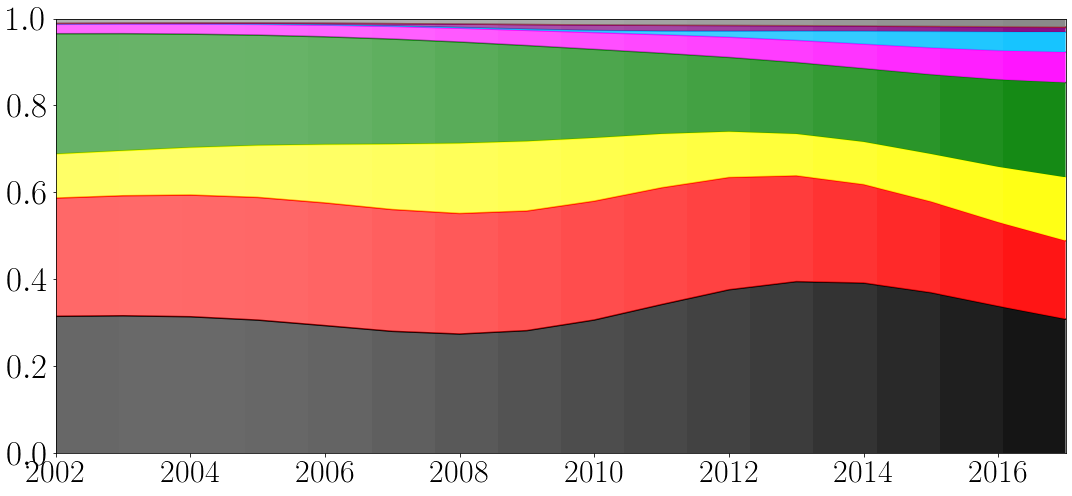

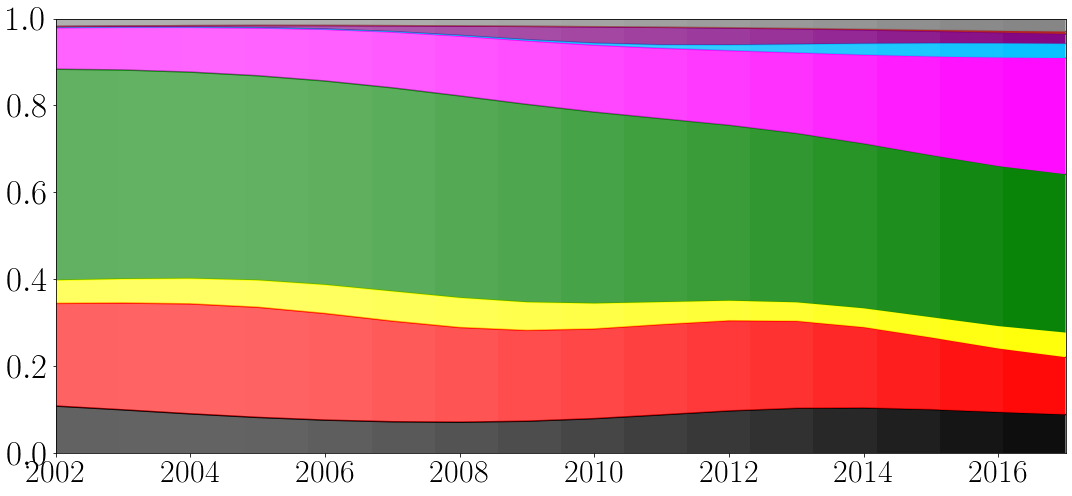

In [87]:
sm_cum_results_samples = [sm_s_cumulative_Markt, sm_s_cumulative_Wanne, sm_s_cumulative_Franz]

results_v_samples = [sample_pred_Markt_std, sample_pred_Wanne_std, sample_pred_Franz_std]


filenames2 = ['Tübingen_samples_Markt.png', 'Tübingen_samples_Wanne.png', 'Tübingen_samples_Franz.png']


for i in range(len(sm_cum_results_samples)):
    
    r = sm_cum_results_samples[i]
    v = np.sqrt(results_v_samples[i])
    plot_cum_results2(r, v, save=False, filename=filenames2[i], legend=False)
    

# Playground

In [93]:
election_GP_samples_mean = np.mean(election_GP_samples, 0)
election_GP_samples_std = np.std(election_GP_samples, 0)

print(np.shape(election_GP_samples))
print(np.shape(sample_mean))

(50, 16, 27)
(135,)


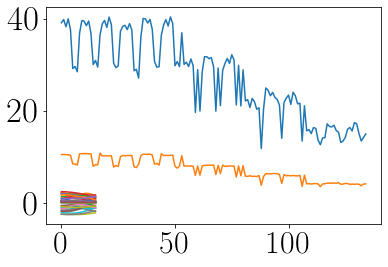

In [92]:
plt.plot(sample_mean)
plt.plot(sample_std)
plt.plot(election_GP_samples_mean)
plt.plot(election_GP_samples_std)
plt.show();

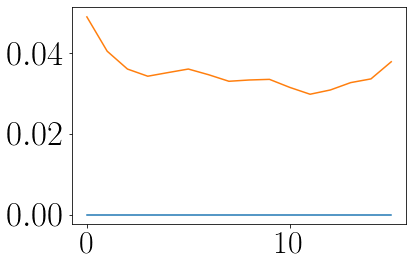

In [118]:
#plt.plot(sample_pred_Markt_std)
sm_cumulative_GP_samples_Markt_std = sm_cumulative_Markt_GP_s.std(0)

plt.plot(sm_cumulative_GP_samples_Markt_std[:,8])
plt.plot(Tübingen_pred_Markt_v[:,8])
plt.show()

In [103]:
print(np.shape(sm_cumulative_GP_samples_Markt_std))
print(np.shape(Tübingen_pred_Markt_v))

(16, 9)
(16, 9)


In [122]:
Tübingen_pred_Markt_std_up = Tübingen_pred_Markt + np.sqrt(Tübingen_pred_Markt_v)

sm_results_Markt_std_up = softmax_batch(Tübingen_pred_Markt_std_up)
sm_cumulative_Markt_std_up = np.cumsum(sm_results_Markt_std_up, 1)

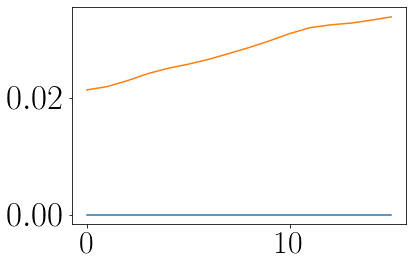

In [136]:
i = 8
plt.plot(sm_cumulative_GP_samples_Markt_std[:,i])
plt.plot(sm_results_Markt_std_up[:,i])
plt.show()